# Segment 2 Lab 2

## A real world case study

We will look at prices of actual products scraped from Amazon

We have details of the products, along with key features.

We'll first examine the data, then we'll run Regression

In [1]:
# imports

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
from loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
from tqdm import tqdm
import pickle
import json

# Downloading the Pickle files

I've made convenient pkl files with the training and test data for the remaining labs.

Sadly, they are a bit too large to go in git. I've uploaded them to Google Drive and you can fetch them here:  
https://drive.google.com/drive/folders/1Imh1NNSsVDXkUWpkeape0hTYL1QROCvj?usp=sharing

Please download them and place them in the project root directory (i.e. the `tech2ai` directory, the parent of this current directory).

If these files are too large for you, please message me and I will make you a smaller dataset!

In [2]:
# Once you have the pickle files in the tech2ai directory (above this one), you can load in dataset

with open('../training_data.pkl', 'rb') as file:
    train = pickle.load(file)

with open('../test_data.pkl', 'rb') as file:
    test = pickle.load(file)

In [4]:
items = train + test
print(f"There are {len(items):,} items, split into {len(train):,} training and {len(test):,} test points")

There are 278,636 items, split into 277,220 training and 1,416 test points


## An essential first step to all types of Data Science:

# Investigate the data!

Each item in our dataset has a category, and it has 3 features: weight, rank (best-seller's rank) and timestamp (when was it released)

In [5]:
categories = list(set(item.category for item in items))
counts = [len([item for item in items if item.category==category]) for category in categories]

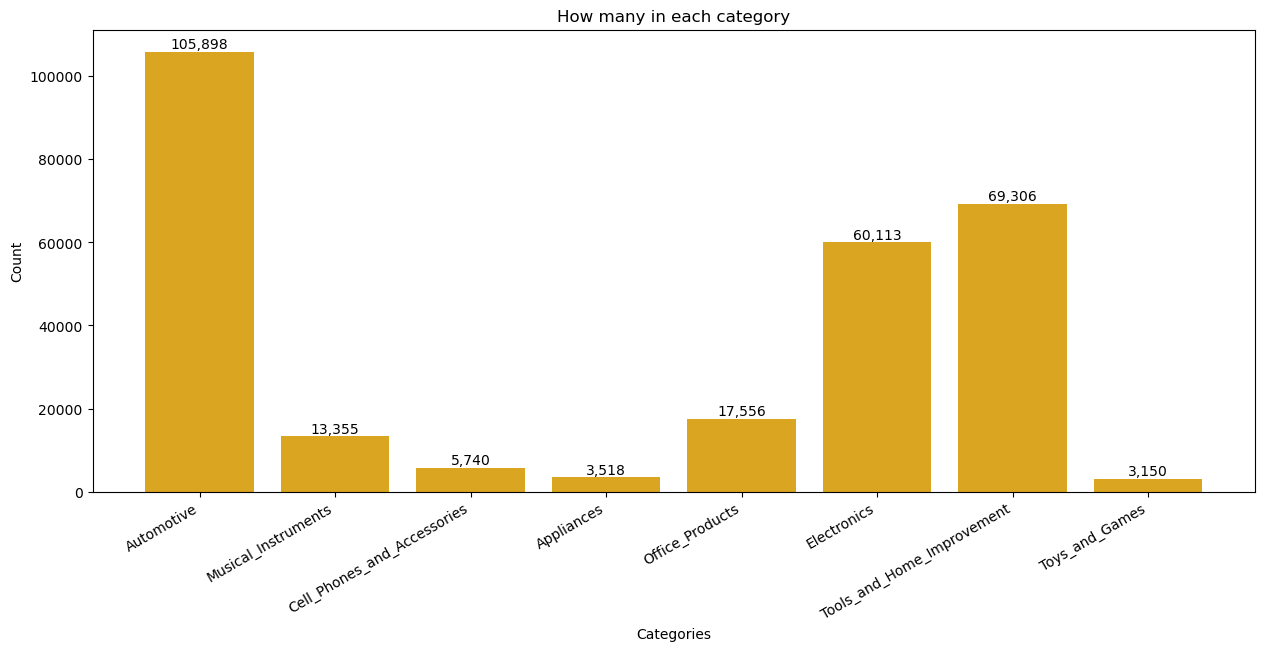

In [6]:

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

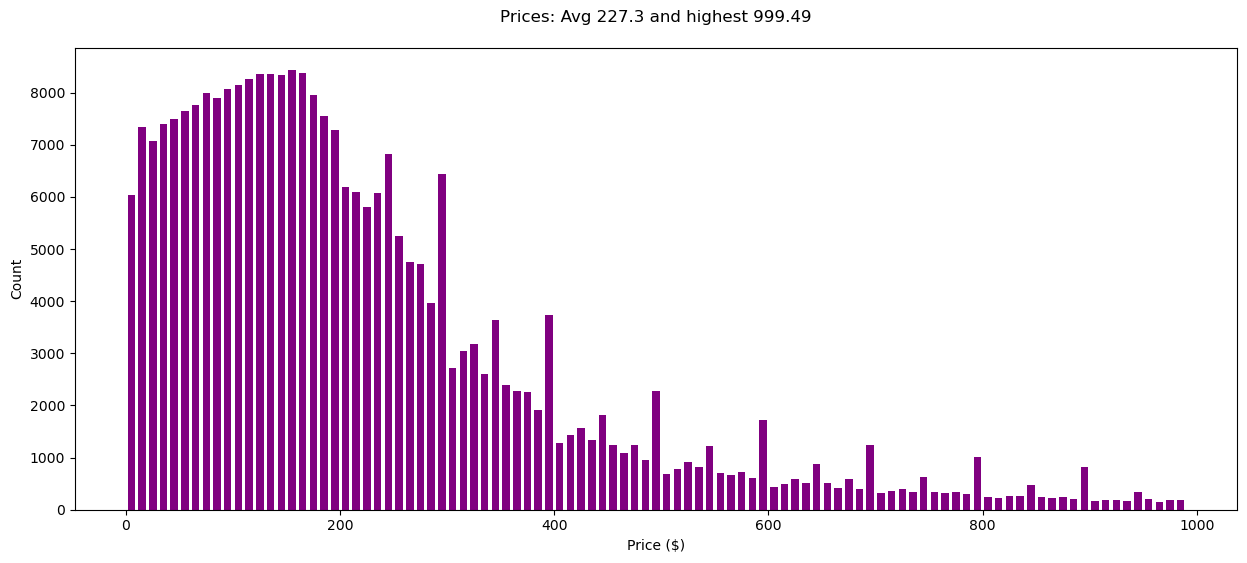

In [7]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 1000, 10))
plt.show()

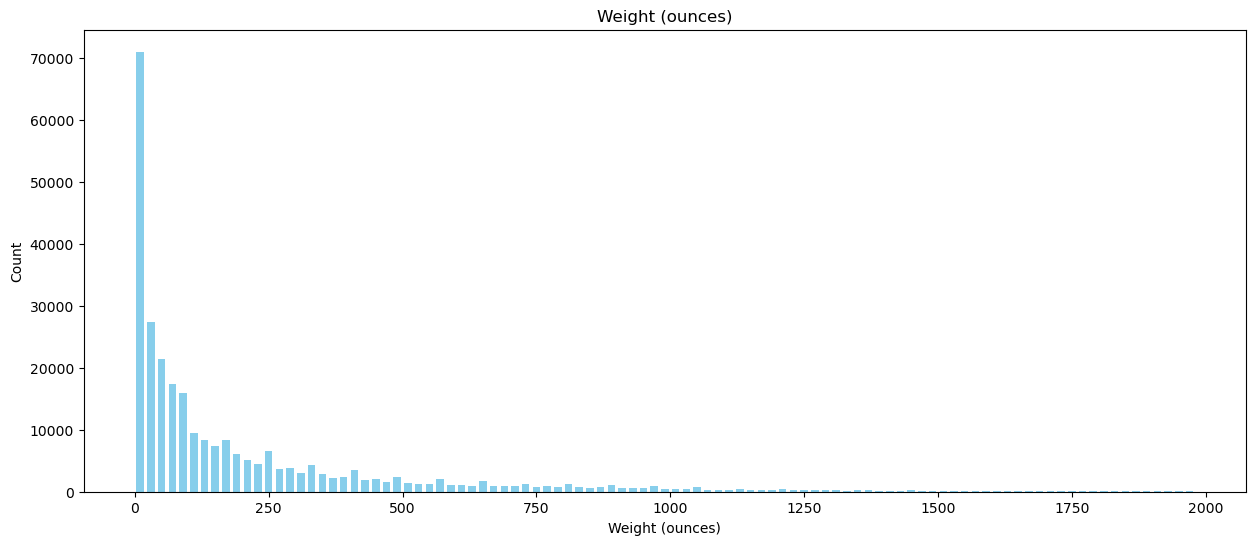

In [9]:
# Plot the distribution of weights

weights = [item.weight for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Weight (ounces)")
plt.xlabel('Weight (ounces)')
plt.ylabel('Count')
plt.hist(weights, rwidth=0.7, color="skyblue", bins=range(0, 2000, 20))
plt.show()

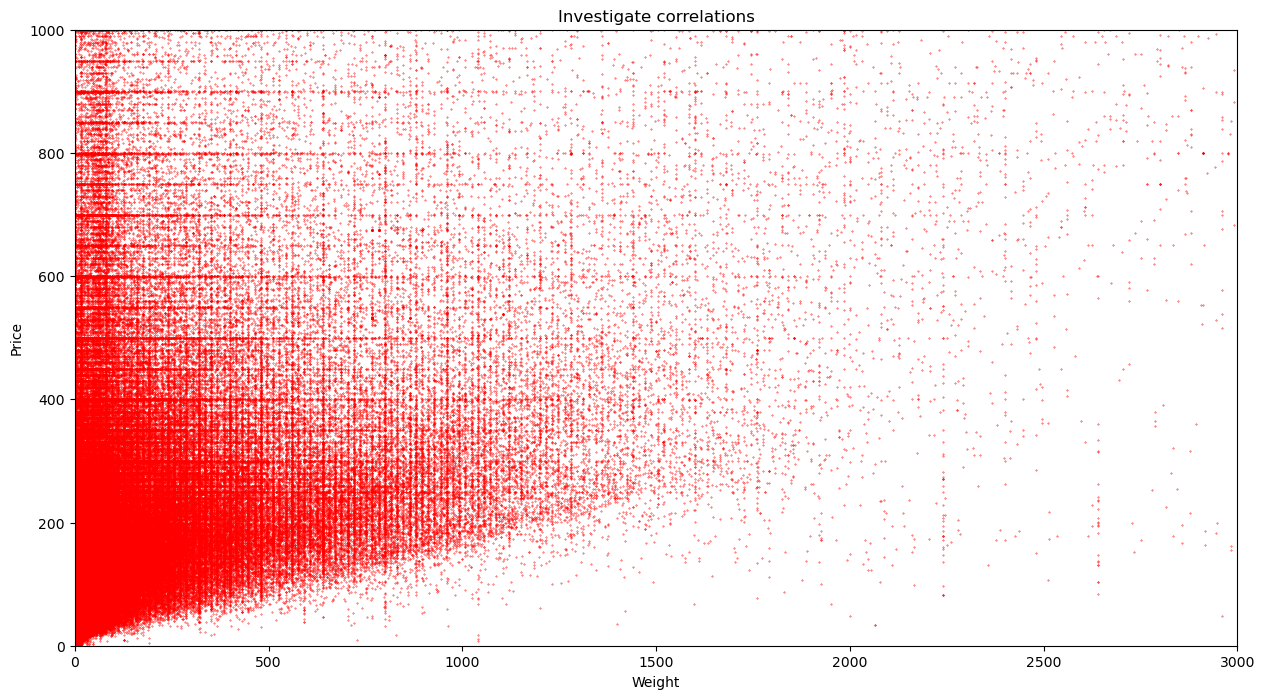

In [11]:
# How does the price vary with the weight

weights = [item.weight for item in items]
prices = [item.price for item in items]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(weights, prices, s=0.1, color="red")
plt.xlim(0, 3000)
plt.ylim(0, 1000)

# Add labels and title
plt.xlabel('Weight')
plt.ylabel('Price')
plt.title('Investigate correlations')

# Display the plot
plt.show()

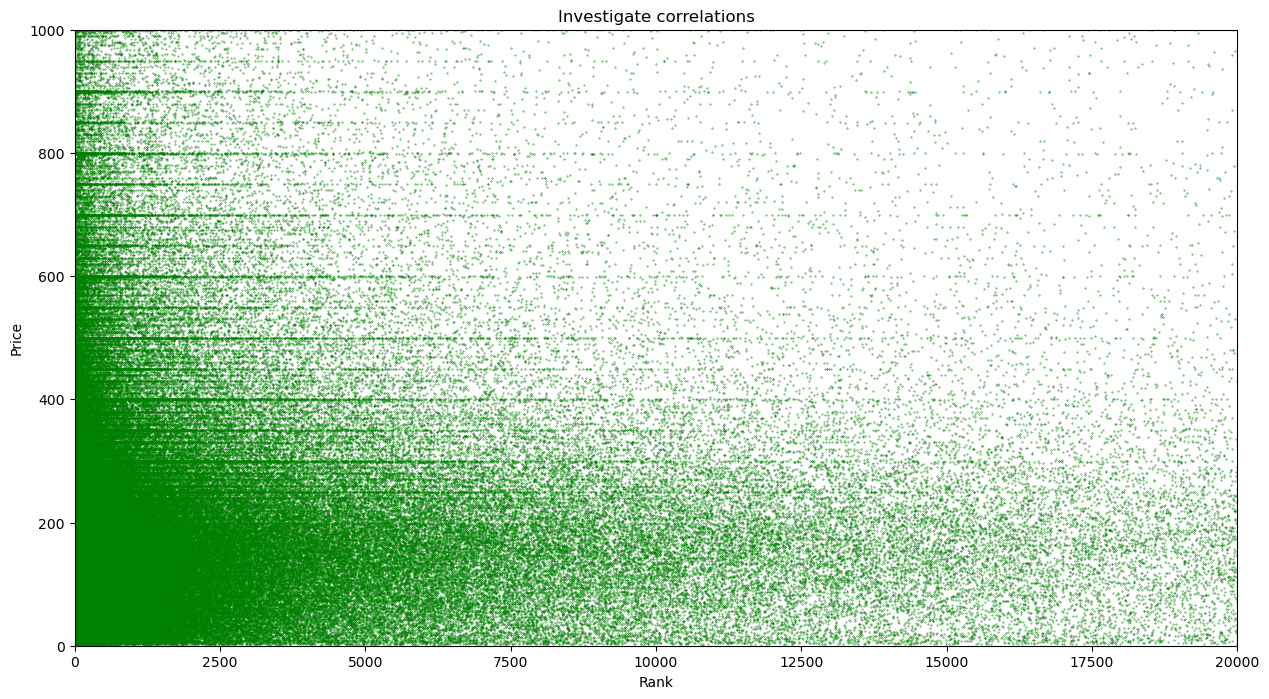

In [22]:
# How does the price vary with how high the product ranks in Amazon best seller lists
import math
ranks = [item.rank for item in items]
prices = [item.price for item in items]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(ranks, prices, s=0.1, color="green")
plt.xlim(0, 20000)
plt.ylim(0, 1000)

# Add labels and title
plt.xlabel('Rank')
plt.ylabel('Price')
plt.title('Investigate correlations')

# Display the plot
plt.show()

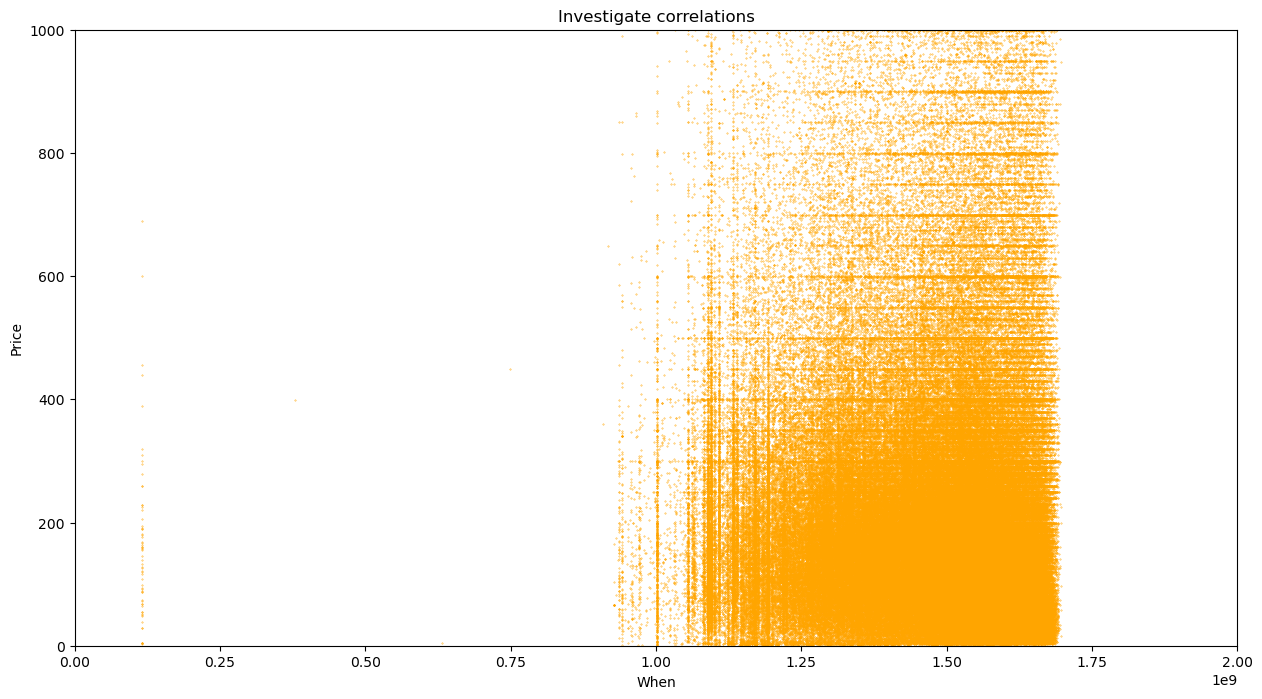

In [23]:
# How does the price vary with the timestamp - when it was first released

when = [item.timestamp for item in items]
prices = [item.price for item in items]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(when, prices, s=0.1, color="orange")
plt.ylim(0, 1000)
plt.xlim(0, 2e9)

# Add labels and title
plt.xlabel('When')
plt.ylabel('Price')
plt.title('Investigate correlations')

# Display the plot
plt.show()

In [24]:
# Imports for machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from testing import Tester

In [25]:
# Before we start our Linear Regression, let's have some fun
# Let's make a terrible model that simply guesses the answer!!

def guess(item):
    return random.randrange(1,1000)

In [26]:
# Set random seed so that our results can be reproduced

random.seed(42)

1: Guess: $655.00 Truth: $374.41 Error: $280.59 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $115.00 Truth: $225.11 Error: $110.11 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $26.00 Truth: $61.68 Error: $35.68 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $760.00 Truth: $599.99 Error: $160.01 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $282.00 Truth: $101.79 Error: $180.21 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
6: Guess: $251.00 Truth: $289.00 Error: $38.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
7: Guess: $229.00 Truth: $412.99 Error: $183.99 Item: CURT 70110 Custom Tow Bar Base Plate Bra...
8: Guess: $143.00 Truth: $248.23 Error: $105.23 Item: COSTWAY Electric Tumble Dryer, Sliver
9: Guess: $755.00 Truth: $399.00 Error: $356.00 Item: FREE SIGNAL TV Transit 32" 12 Volt DC Po...
10: Guess: $105.00 Truth: $373.94 Error: $268.94 Item: Bilstein 5100 Monotube Gas Shock Set com...
11: Guess: $693.00 Truth: $92.89 Error: $600

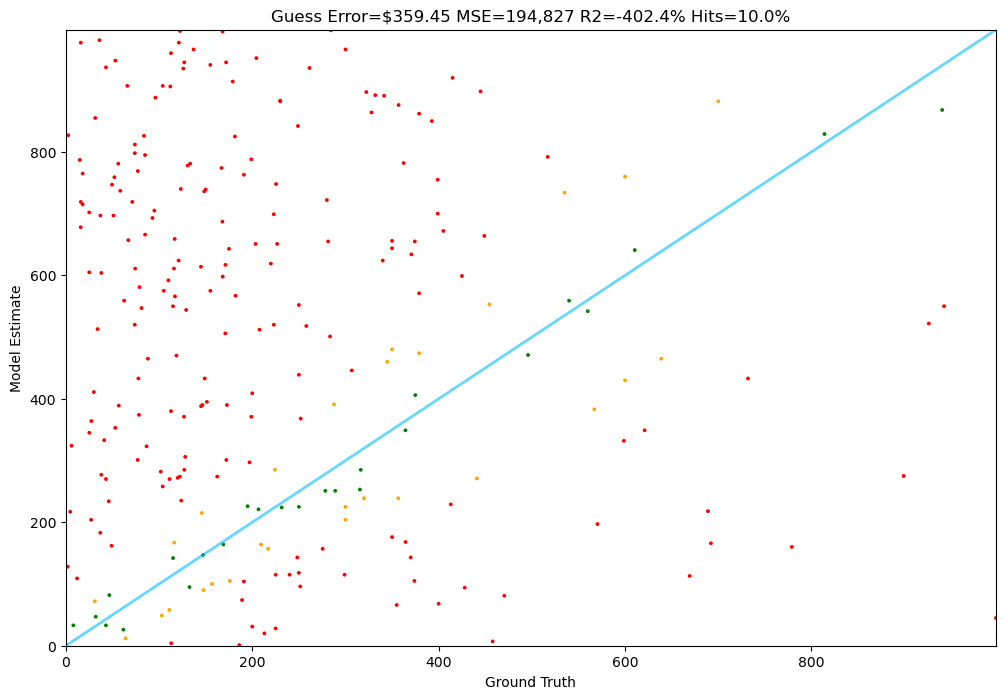

In [27]:
# This is a useful function I wrote that takes a function to test, and a dataset

Tester.test(guess, test)

In [28]:
# Another amusingly basic model, but perhaps a bit better than the last one!

train_prices = [t.price for t in train]
train_average = sum(train_prices)/len(train_prices)

def guess2(item):
    return train_average

1: Guess: $227.30 Truth: $374.41 Error: $147.11 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $227.30 Truth: $225.11 Error: $2.19 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $227.30 Truth: $61.68 Error: $165.62 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $227.30 Truth: $599.99 Error: $372.69 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $227.30 Truth: $101.79 Error: $125.51 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
6: Guess: $227.30 Truth: $289.00 Error: $61.70 Item: Godox ML60Bi LED Light Kit, Handheld LED...
7: Guess: $227.30 Truth: $412.99 Error: $185.69 Item: CURT 70110 Custom Tow Bar Base Plate Bra...
8: Guess: $227.30 Truth: $248.23 Error: $20.93 Item: COSTWAY Electric Tumble Dryer, Sliver
9: Guess: $227.30 Truth: $399.00 Error: $171.70 Item: FREE SIGNAL TV Transit 32" 12 Volt DC Po...
10: Guess: $227.30 Truth: $373.94 Error: $146.64 Item: Bilstein 5100 Monotube Gas Shock Set com...
11: Guess: $227.30 Truth: $92.89 Error: $134.

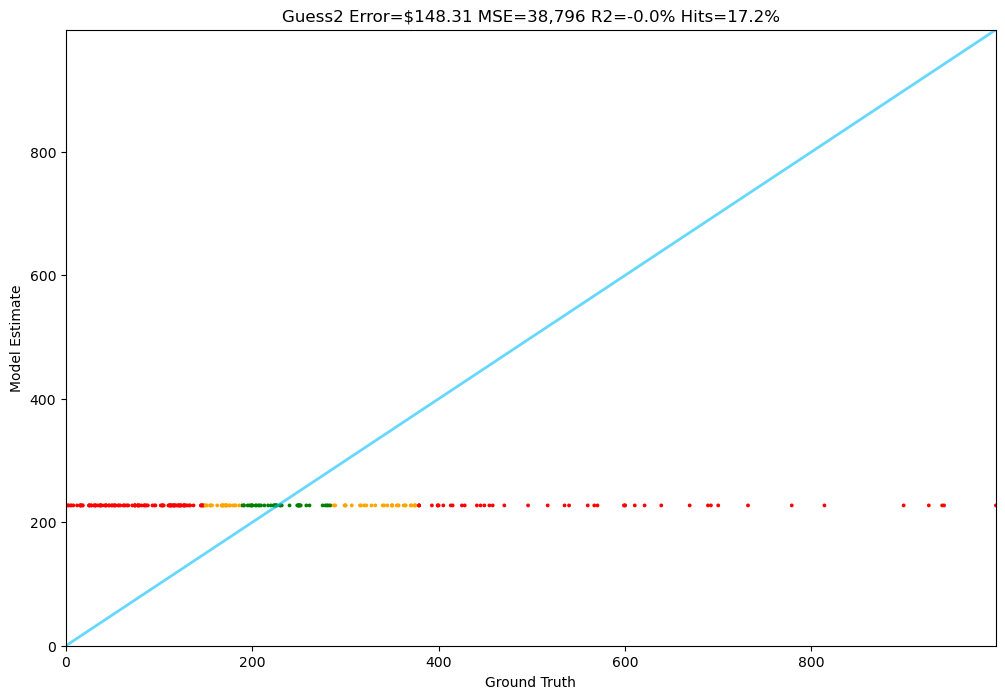

In [29]:
Tester.test(guess2, test)

In [40]:
# Now let's do linear regression with our features

def get_features(item):
    return {
        "weight": item.weight,
        "rank": item.rank,
        "timestamp": item.timestamp,
        "is_top_tech": 1 if item.is_top_tech else 0,
        "is_top_toys": 1 if item.is_top_toys else 0,
        "price": item.price
    }

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [41]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'timestamp', "is_top_tech", "is_top_toys"]

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [42]:
# What were the model parameters for our features?

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef:.7f}")
print(f"Intercept: {model.intercept_}")

weight: 0.0164744
rank: -0.0001479
timestamp: 0.0000000
is_top_tech: 64.8383159
is_top_toys: -88.3227132
Intercept: 222.03450854220347


In [43]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    del features["price"]
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $227.61 Truth: $374.41 Error: $146.80 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $224.34 Truth: $225.11 Error: $0.77 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $223.62 Truth: $61.68 Error: $161.94 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $223.71 Truth: $599.99 Error: $376.28 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $223.82 Truth: $101.79 Error: $122.03 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
6: Guess: $226.31 Truth: $289.00 Error: $62.69 Item: Godox ML60Bi LED Light Kit, Handheld LED...
7: Guess: $235.02 Truth: $412.99 Error: $177.97 Item: CURT 70110 Custom Tow Bar Base Plate Bra...
8: Guess: $226.05 Truth: $248.23 Error: $22.18 Item: COSTWAY Electric Tumble Dryer, Sliver
9: Guess: $225.10 Truth: $399.00 Error: $173.90 Item: FREE SIGNAL TV Transit 32" 12 Volt DC Po...
10: Guess: $229.68 Truth: $373.94 Error: $144.26 Item: Bilstein 5100 Monotube Gas Shock Set com...
11: Guess: $223.47 Truth: $92.89 Error: $130.

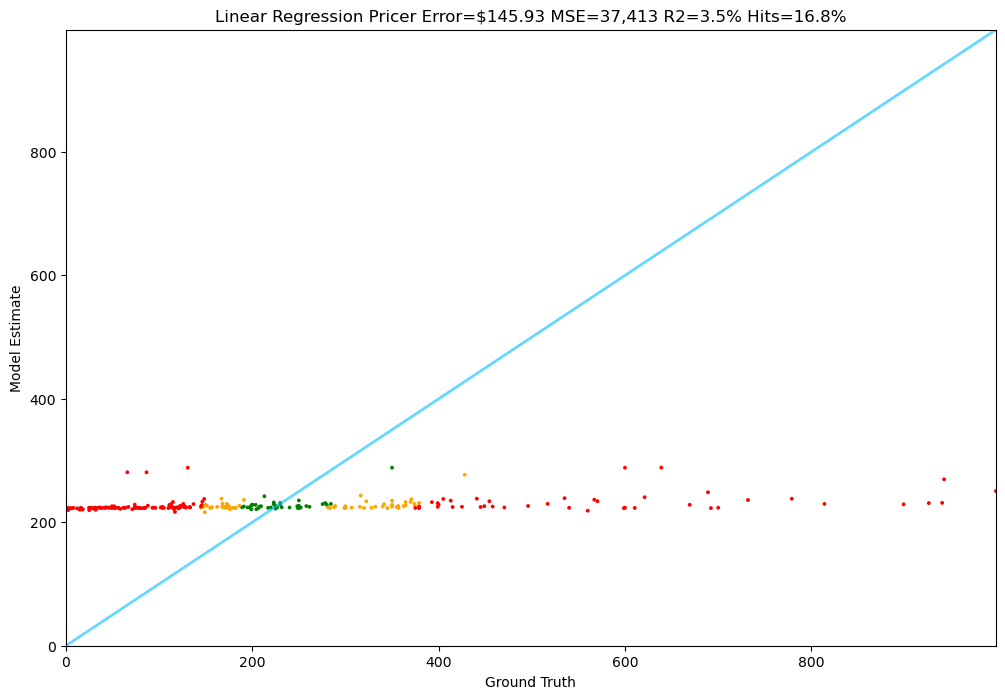

In [44]:
# test it

Tester.test(linear_regression_pricer, test)

In [45]:
# Here is a short description of each item

train[0].text

'Delphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7'

In [46]:
# For the next few models, we prepare our documents and prices

prices = np.array([float(item.price) for item in train])
documents = [item.text for item in train]

In [47]:
documents[0]

'Delphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7'

In [48]:
# Use the CountVectorizer
# This changes a paragraph of text into a list of numbers, i.e. a vector
# How does it do that? It just counts the number of times words appear!

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)

In [49]:
# Here are the 1,000 most common words that it picked, not including "stop words":

selected_words = vectorizer.get_feature_names_out()
print(f"Number of selected words: {len(selected_words)}")
print("Selected words:", selected_words)

Number of selected words: 1000
Selected words: ['000' '10' '100' '1000' '1080p' '11' '12' '120' '13' '14' '15' '150'
 '1500' '16' '16gb' '17' '18' '19' '1x' '20' '200' '2000' '2003' '2004'
 '2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014'
 '2015' '2016' '2017' '2018' '2019' '2020' '21' '22' '23' '24' '25' '2500'
 '26' '27' '28' '2x' '30' '300' '32' '35' '36' '360' '40' '45' '48' '4k'
 '50' '500' '60' '75' '80' '8gb' '90' 'abs' 'ac' 'access' 'accessories'
 'accessory' 'acdelco' 'adapter' 'add' 'added' 'addition' 'additional'
 'adjust' 'adjustable' 'adjustment' 'advanced' 'affordable' 'aftermarket'
 'air' 'allow' 'allowing' 'allows' 'alloy' 'aluminum' 'amazon' 'amd'
 'american' 'amp' 'amplifier' 'android' 'angle' 'anti' 'app' 'appearance'
 'apple' 'application' 'applications' 'approved' 'area' 'arm' 'art'
 'assembled' 'assemblies' 'assembly' 'audio' 'auto' 'automatic'
 'automotive' 'available' 'axle' 'backed' 'bag' 'ball' 'band' 'bar' 'bars'
 'base' 'based' 'bass' 'b

0

In [54]:
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [55]:
# Now we create a model to use this for prediction

def bag_of_words(item):
    x = vectorizer.transform([item.text])
    return max(regressor.predict(x)[0], 0)

1: Guess: $286.49 Truth: $374.41 Error: $87.92 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $153.10 Truth: $225.11 Error: $72.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $149.24 Truth: $61.68 Error: $87.56 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $361.10 Truth: $599.99 Error: $238.89 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $338.20 Truth: $101.79 Error: $236.41 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
6: Guess: $275.76 Truth: $289.00 Error: $13.24 Item: Godox ML60Bi LED Light Kit, Handheld LED...
7: Guess: $345.32 Truth: $412.99 Error: $67.67 Item: CURT 70110 Custom Tow Bar Base Plate Bra...
8: Guess: $232.13 Truth: $248.23 Error: $16.10 Item: COSTWAY Electric Tumble Dryer, Sliver
9: Guess: $253.40 Truth: $399.00 Error: $145.60 Item: FREE SIGNAL TV Transit 32" 12 Volt DC Po...
10: Guess: $301.67 Truth: $373.94 Error: $72.27 Item: Bilstein 5100 Monotube Gas Shock Set com...
11: Guess: $289.23 Truth: $92.89 Error: $196.34 

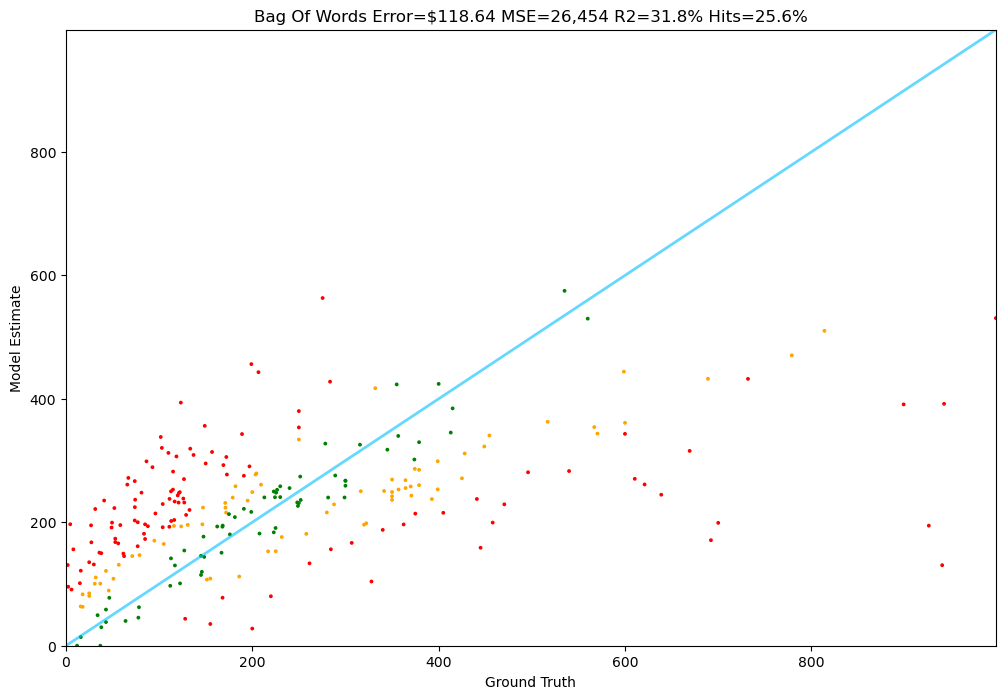

In [56]:
Tester.test(bag_of_words, test)

In [ ]:
# And the powerful Random Forest regression

subset=400_000
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X[:subset], prices[:subset])

In [60]:
def random_forest(item):
    x = vectorizer.transform([item.text])
    return max(0, rf_model.predict(x)[0])

1: Guess: $306.43 Truth: $374.41 Error: $67.98 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $164.17 Truth: $225.11 Error: $60.94 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $146.81 Truth: $61.68 Error: $85.13 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $343.09 Truth: $599.99 Error: $256.90 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $223.18 Truth: $101.79 Error: $121.39 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
6: Guess: $207.73 Truth: $289.00 Error: $81.27 Item: Godox ML60Bi LED Light Kit, Handheld LED...
7: Guess: $349.87 Truth: $412.99 Error: $63.12 Item: CURT 70110 Custom Tow Bar Base Plate Bra...
8: Guess: $186.39 Truth: $248.23 Error: $61.84 Item: COSTWAY Electric Tumble Dryer, Sliver
9: Guess: $349.18 Truth: $399.00 Error: $49.82 Item: FREE SIGNAL TV Transit 32" 12 Volt DC Po...
10: Guess: $373.92 Truth: $373.94 Error: $0.02 Item: Bilstein 5100 Monotube Gas Shock Set com...
11: Guess: $321.28 Truth: $92.89 Error: $228.39 It

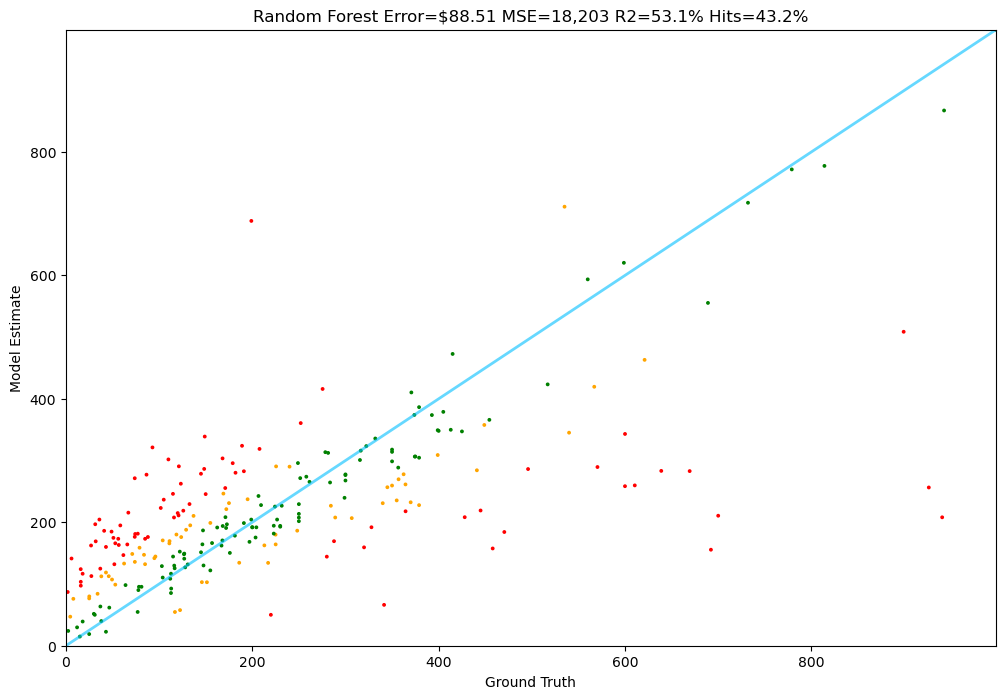

In [61]:
Tester.test(random_forest, test)

# Exercises

Try engineering more features

Try different models from traditional machine learning, such as Support Vector Machines